# 第3章 特徴語

In [1]:
# これまでに定義した関数の読み込み

from chapter01 import get_string_from_file
from chapter02 import create_wordcloud, get_japanese_fonts

%matplotlib inline

## 3.2 不要語

In [2]:
# Listing 3.1 #

from janome.analyzer import Analyzer
from janome.tokenfilter import ExtractAttributeFilter
from janome.tokenfilter import POSStopFilter

string = '京都とは違う奈良の魅力'
stop_pos = ['助詞', '助動詞', '記号']
analyzer = Analyzer(token_filters=[POSStopFilter(stop_pos),
                                   ExtractAttributeFilter('surface')])
print(list(analyzer.analyze(string)))

['京都', '違う', '奈良', '魅力']


In [3]:
# Listing 3.2 #

from janome.tokenfilter import POSKeepFilter

string = '京都とは違う奈良の魅力'
keep_pos = ['名詞']
analyzer = Analyzer(token_filters=[POSKeepFilter(keep_pos),
                                   ExtractAttributeFilter('surface')])
print(list(analyzer.analyze(string)))

['京都', '奈良', '魅力']


In [4]:
# Listing 3.3 #

def get_words(string, keep_pos=None):
    filters = []
    if keep_pos is None:
        filters.append(POSStopFilter(['記号']))       # 記号を除外
    else:
        filters.append(POSKeepFilter(keep_pos))       # 指定品詞を抽出
    filters.append(ExtractAttributeFilter('surface'))
    a = Analyzer(token_filters=filters)               # 後処理を指定
    return list(a.analyze(string))

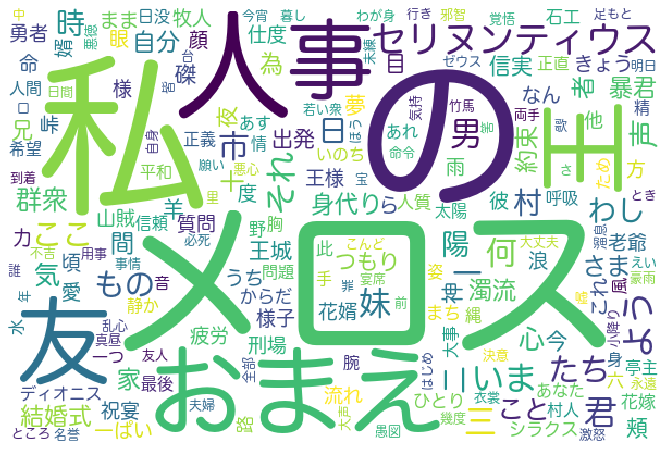

In [5]:
# Listing 2.1 の get_words を置き換えたもの #

from collections import Counter

string = get_string_from_file('data/ch01/melos.txt')
words = get_words(string, keep_pos=['名詞'])
count = Counter(words)
font = get_japanese_fonts()[0]
create_wordcloud(count, font)

## 3.3 TF・IDF

In [6]:
# Listing 3.4 #

from pprint import pprint

D = ['data/ch03/1.txt', 'data/ch03/2.txt']
texts = [get_string_from_file(x) for x in D]
pprint(texts, width=40)

['春は私の好きな季節だけど花粉が怖い',
 '私は梅も桜も好きで，特に桜の香りが好きだ']


In [7]:
# Listing 3.5 #

docs = [get_words(x, keep_pos=['名詞']) for x in texts]
pprint(docs, width=40)

[['春', '私', '好き', '季節', '花粉'],
 ['私', '梅', '桜', '好き', '桜', '香り', '好き']]


In [8]:
# Listing 3.6 #

from gensim import corpora

# docsからcorpora.Dictionaryオブジェクトを生成
dictionary = corpora.Dictionary(docs)
#文字列とIDの組を順に表示
for k, v in dictionary.items():
    print(k, v)

0 好き
1 季節
2 春
3 私
4 花粉
5 桜
6 梅
7 香り


In [9]:
# Listing 3.7 #

i = 2
s = '花粉'
# dictionary[i]でID iから文字列へ
print('ID={}の語は「{}」'.format(i, dictionary[i]))
# dictionary.token2id[s]で文字列sからIDへ
print('「{}」のIDは{}'.format(s, dictionary.token2id['花粉']))

ID=2の語は「春」
「花粉」のIDは4


In [10]:
# Listing 3.8 #

bows = [dictionary.doc2bow(d) for d in docs]
pprint(bows)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(0, 2), (3, 1), (5, 2), (6, 1), (7, 1)]]


In [11]:
# Listing 3.9 #

# コーパスの生成
def build_corpus(file_list, dic_file=None, corpus_file=None):
    docs = []
    for f in file_list:
        text = get_string_from_file(f)
        words = get_words(text, keep_pos=['名詞'])
        docs.append(words)
        # ファイル名を表示
        print(f)
    dic = corpora.Dictionary(docs)
    if not (dic_file is None):
        dic.save(dic_file)
    bows = [dic.doc2bow(d) for d in docs]
    if not (corpus_file is None):
        corpora.MmCorpus.serialize(corpus_file, bows)
    return dic, bows

In [12]:
# Listing 3.10 #

def bows_to_cfs(bows):
    cfs = dict()
    for b in bows:
        for id, f in b:
            if not id in cfs:
                cfs[id] = 0
            cfs[id] += int(f)
    return cfs

def load_dictionary_and_corpus(dic_file, corpus_file):
    dic = corpora.Dictionary.load(dic_file)
    bows = list(corpora.MmCorpus(corpus_file))
    if not hasattr(dic, 'cfs'):
        dic.cfs = bows_to_cfs(bows)
    return dic, bows

In [13]:
# Listing 3.11 #

from gensim import models

# 逆文書頻度(idf)を計算
tfidf_model = models.TfidfModel(bows, normalize=False)
# 2.txt(bows[1])のTF・IDFを計算
weights = tfidf_model[bows[1]]
print(weights)

[(5, 2.0), (6, 1.0), (7, 1.0)]


In [14]:
# Listing 3.12 #

def load_aozora_corpus():
    return load_dictionary_and_corpus('data/aozora/aozora.dic',
                                                           'data/aozora/aozora.mm')

def get_bows(texts, dic, allow_update=False):
    bows = []
    for text in texts:
        words = get_words(text, keep_pos=['名詞'])
        bow = dic.doc2bow(words, allow_update=allow_update)
        bows.append(bow)
    return bows

import copy

def add_to_corpus(texts, dic, bows, replicate=False):
    if replicate:
        dic = copy.copy(dic)
        bows = copy.copy(bows)
    texts_bows = get_bows(texts, dic, allow_update=True)
    bows.extend(texts_bows)
    return dic, bows, texts_bows

In [15]:
# Listing 3.13 #

def get_weights(bows, dic, model, surface=False, N=1000):
    # TF・IDFを計算
    weights = model[bows]
    # TF・IDFの値を基準に降順にソート．最大でN個を抽出
    weights = [sorted(w,key=lambda x:x[1], reverse=True)[:N] for w in weights]
    if surface:
        return [[(dic[x[0]], x[1]) for x in w] for w in weights]
    else:
        return weights

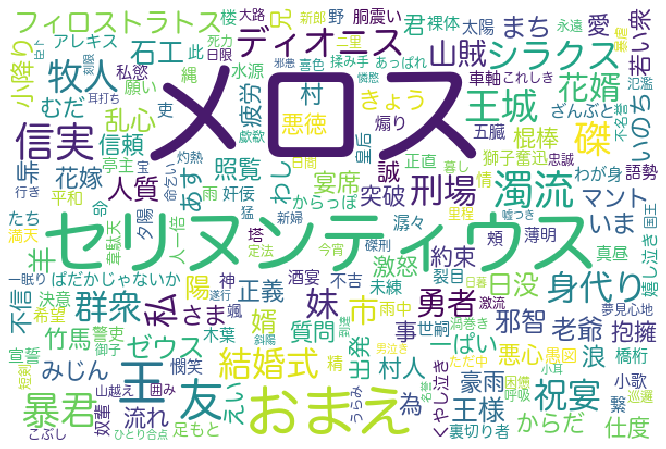

In [16]:
# Listing 3.14 #

# 青空文庫コーパスの読み込み
dic, bows = load_aozora_corpus()

# 「走れメロス」のデータの読み込み
melos_text = get_string_from_file('data/ch01/melos.txt')

# コーパスへの追加
dic, bows, melos_bows = add_to_corpus([melos_text], dic, bows)

# modelを作成
tfidf_model = models.TfidfModel(bows, normalize=True)

# TF・IDFを計算．surface=Trueとして表層形(文字列)への変換を指定
weights = get_weights(melos_bows, dic, tfidf_model, surface=True)

# get_weightsの返り値をcreate_wordcloudにあわせて辞書型に変換
count = dict(weights[0])

# ワードクラウドを作成
font = get_japanese_fonts()[0]
create_wordcloud(count, font)

In [17]:
# Listing 3.15 #

def translate_bows(bows, table):
    return [[tuple([table[j[0]], j[1]]) for j in i if j[0] in table] for i in bows]

def get_tfidfmodel_and_weights(texts, use_aozora=True, pos=['名詞']):
    if use_aozora:
        dic, bows = load_aozora_corpus()
    else:
        dic = corpora.Dictionary()
        bows = []
    
    text_docs = [get_words(text, keep_pos=pos) for text in texts]
    text_bows = [dic.doc2bow(d, allow_update=True) for d in text_docs]
    bows.extend(text_bows)
    
    # textsに現れる語のidとtoken(表層形)のリストを作成
    text_ids = list(set([text_bows[i][j][0] for i in range(len(text_bows)) for j in range(len(text_bows[i]))]))
    text_tokens = [dic[i] for i in text_ids]
    
    # text_bowsにない語を削除．
    dic.filter_tokens(good_ids=text_ids)
    # 削除前後のIDの対応づけ
    # Y = id2id[X] として古いid X から新しいid Y が得られるようになる
    id2id = dict()
    for i in range(len(text_ids)):
        id2id[text_ids[i]] = dic.token2id[text_tokens[i]]
    
    # 語のIDが振り直されたのにあわせてbowを変換
    bows = translate_bows(bows, id2id)
    text_bows = translate_bows(text_bows, id2id)
    
    # TF・IDFモデルを作成
    tfidf_model = models.TfidfModel(bows, normalize=True)
    # モデルに基づいて重みを計算
    text_weights = get_weights(text_bows, dic, tfidf_model)
    
    return tfidf_model, dic, text_weights